In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(2025)

In [4]:
from src.data_reading import read_movies_file, read_users_file, read_ratings_file 

In [5]:
movies = read_movies_file() 
ratings = read_ratings_file() 
users = read_users_file()

In [6]:
ratings.head(2)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109


In [7]:
# Let's conduct the sparsity analysis
n_users = ratings.user_id.nunique()
n_movies = ratings.movie_id.nunique()
n_ratings = ratings.shape[0]

sparsity = np.round((1 - n_ratings / (n_users * n_movies)) * 100, 2)
sparsity

np.float64(95.53)

The sparsity level in our dataset is 95.53%.

In [8]:
ratings_per_user = ratings.groupby('user_id').size()
ratings_per_user.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

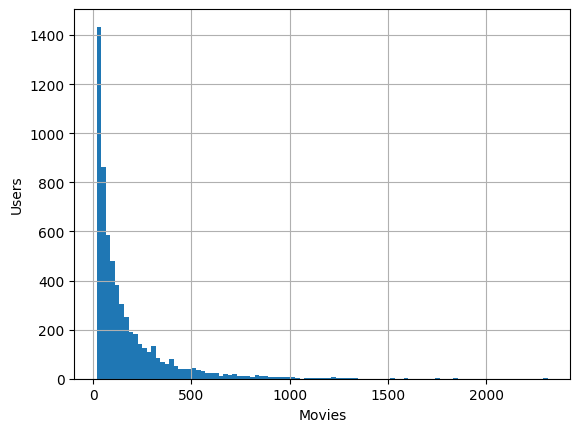

In [9]:
ratings_per_user.hist(bins=100)
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()

In the dataset there is no users with less than 20 ratings, so we can say there is no cold starts users at least in the dataset.

## Ratings Matrix

Create a pivot table to represent the user-item ratings matrix.

In [9]:
ratings_matrix = ratings.pivot_table(
    index='user_id', 
    columns='movie_id', 
    values='rating', 
    fill_value=0
)

print("Ratings matrix shape:", ratings_matrix.shape)
ratings_matrix.head()

Ratings matrix shape: (6040, 3706)


movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualizations

### Sparsity Heatmap

Visualize the sparsity pattern in the ratings matrix. White areas indicate missing ratings.

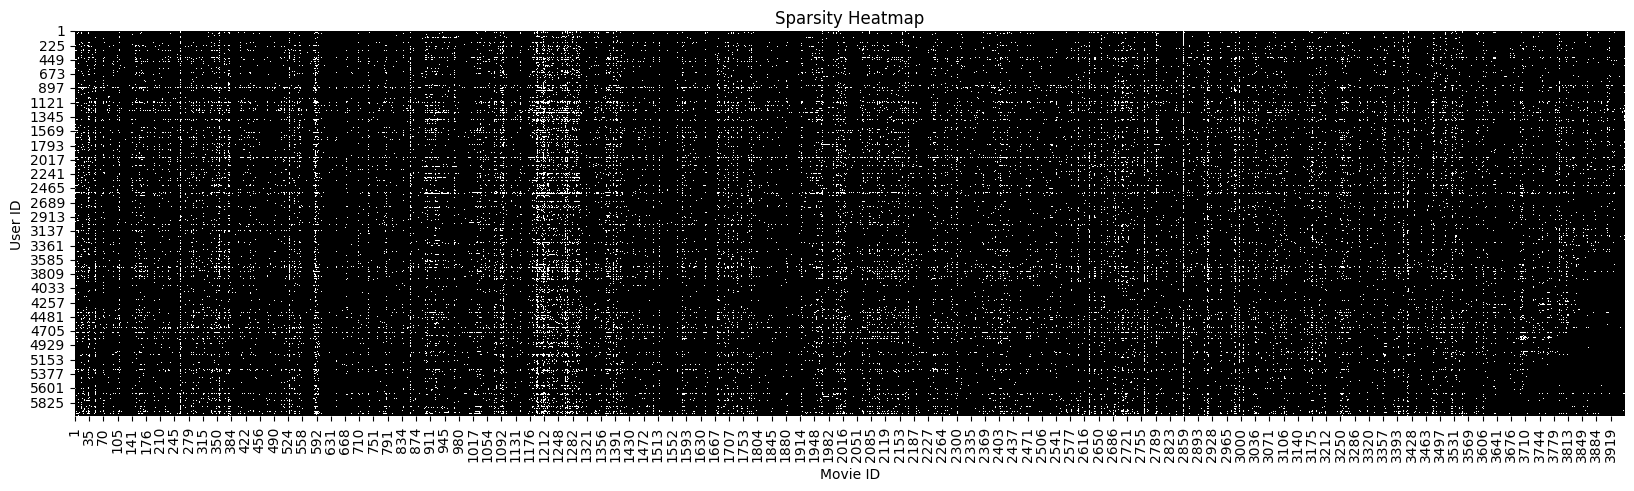

In [10]:
plt.figure(figsize=(20, 5))
sns.heatmap((ratings_matrix == 0), cbar=False, cmap="binary")
plt.title("Sparsity Heatmap")
plt.xlabel("Movie ID")
plt.ylabel("User ID")
plt.show()

### Rating Distribution

How are ratings distributed across the dataset?

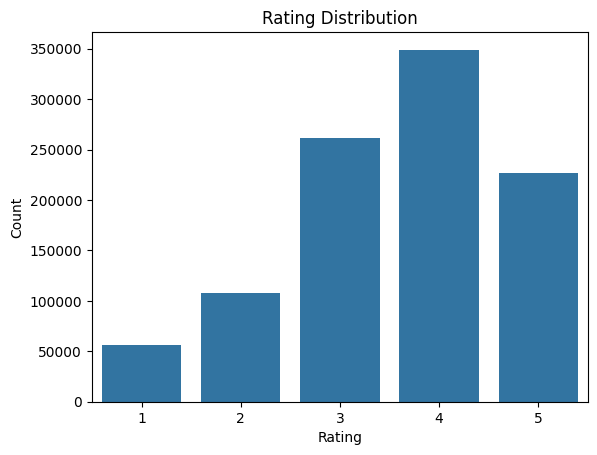

In [11]:
sns.countplot(x='rating', data=ratings)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

### Movie Ratings Distribution

How many ratings does each movie typically receive?

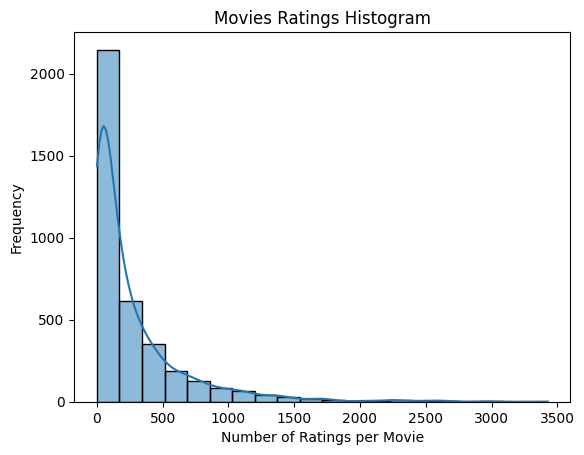

In [12]:
sns.histplot(ratings.groupby('movie_id').size(), bins='doane', kde=True)
plt.title("Movies Ratings Histogram")
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Frequency")
plt.show()

Pathology 1: Popularity Skew (Long-Tail Distribution)¶
Most items receive few ratings while a small number of popular items dominate.

In [13]:
# Analyze item popularity distribution
movie_ratings_count = ratings.groupby('movie_id').size().sort_values(ascending=False)

# Calculate concentration metrics
total_ratings = len(ratings)
top_1_percent = int(len(movie_ratings_count) * 0.01)
top_5_percent = int(len(movie_ratings_count) * 0.05)
top_10_percent = int(len(movie_ratings_count) * 0.10)
top_20_percent = int(len(movie_ratings_count) * 0.20)

concentration_1 = (movie_ratings_count.head(top_1_percent).sum() / total_ratings) * 100
concentration_5 = (movie_ratings_count.head(top_5_percent).sum() / total_ratings) * 100
concentration_10 = (movie_ratings_count.head(top_10_percent).sum() / total_ratings) * 100
concentration_20 = (movie_ratings_count.head(top_20_percent).sum() / total_ratings) * 100

print("Popularity Concentration Analysis:")
print("="*60)
print(f"Top 1% of movies ({top_1_percent} movies) receive {concentration_1:.2f}% of all ratings")
print(f"Top 5% of movies ({top_5_percent} movies) receive {concentration_5:.2f}% of all ratings")
print(f"Top 10% of movies ({top_10_percent} movies) receive {concentration_10:.2f}% of all ratings")
print(f"Top 20% of movies ({top_20_percent} movies) receive {concentration_20:.2f}% of all ratings")

print(f"\nLong-tail characteristics:")
print(f"  Median ratings per movie: {movie_ratings_count.median():.0f}")
print(f"  Mean ratings per movie: {movie_ratings_count.mean():.2f}")
print(f"  Movies with < 10 ratings: {(movie_ratings_count < 10).sum()} ({(movie_ratings_count < 10).sum() / len(movie_ratings_count) * 100:.2f}%)")
print(f"  Movies with < 50 ratings: {(movie_ratings_count < 50).sum()} ({(movie_ratings_count < 50).sum() / len(movie_ratings_count) * 100:.2f}%)")
print(f"  Movies with >= 1000 ratings: {(movie_ratings_count >= 1000).sum()} ({(movie_ratings_count >= 1000).sum() / len(movie_ratings_count) * 100:.2f}%)")

Popularity Concentration Analysis:
Top 1% of movies (37 movies) receive 8.73% of all ratings
Top 5% of movies (185 movies) receive 28.28% of all ratings
Top 10% of movies (370 movies) receive 44.38% of all ratings
Top 20% of movies (741 movies) receive 65.16% of all ratings

Long-tail characteristics:
  Median ratings per movie: 124
  Mean ratings per movie: 269.89
  Movies with < 10 ratings: 446 (12.03%)
  Movies with < 50 ratings: 1192 (32.16%)
  Movies with >= 1000 ratings: 207 (5.59%)


### User Ratings Distribution

How many ratings does each user typically provide?

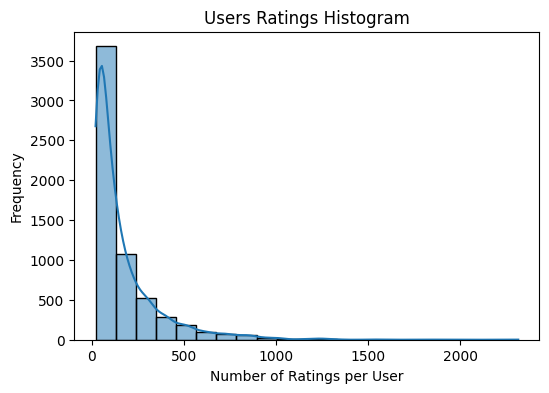

In [14]:
plt.figure(figsize=(6, 4))
sns.histplot(ratings.groupby('user_id').size(), bins='doane', kde=True)
plt.title("Users Ratings Histogram")
plt.xlabel("Number of Ratings per User")
plt.ylabel("Frequency")
plt.show()

### User Behavior Analysis

Relationship between user rating count and their average rating.

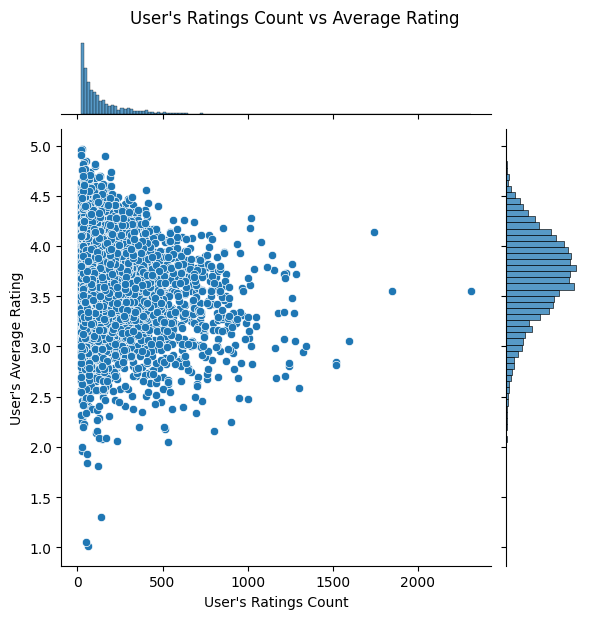

In [15]:
user_stats = ratings.groupby('user_id').agg({'rating': ['mean', 'count']})
user_stats.columns = ['rating_mean', 'rating_count']

g = sns.jointplot(data=user_stats, x='rating_count', y='rating_mean', kind='scatter')
g.set_axis_labels("User's Ratings Count", "User's Average Rating")
g.fig.suptitle("User's Ratings Count vs Average Rating", y=1.025)
plt.show()

#### Pathology: User Cold-Start Problem

While this dataset is pre-filtered (minimum 20 ratings per user), we can still analyze the distribution of user activity levels.

In [16]:
# Analyze user cold-start severity at different thresholds
user_ratings_count = ratings.groupby('user_id').size()

# Define cold-start thresholds
thresholds = [5, 10, 20, 50, 100]

print("User Cold-Start Analysis:")
print("="*60)
for threshold in thresholds:
    count = (user_ratings_count < threshold).sum()
    percentage = (count / len(user_ratings_count)) * 100
    print(f"Users with < {threshold} ratings: {count:>4} ({percentage:>5.2f}%)")

print(f"\nUser activity statistics:")
print(f"  Note: Dataset pre-filtered with minimum 20 ratings per user")
print(f"  Minimum: {user_ratings_count.min()} ratings")
print(f"  25th percentile: {user_ratings_count.quantile(0.25):.0f} ratings")
print(f"  Median: {user_ratings_count.median():.0f} ratings")
print(f"  75th percentile: {user_ratings_count.quantile(0.75):.0f} ratings")
print(f"  Maximum: {user_ratings_count.max()} ratings")
print(f"\nLow-activity users (potential training issues):")
print(f"  Users with 20-30 ratings: {((user_ratings_count >= 20) & (user_ratings_count < 30)).sum()} ({((user_ratings_count >= 20) & (user_ratings_count < 30)).sum() / len(user_ratings_count) * 100:.2f}%)")
print(f"  Users with <50 ratings: {(user_ratings_count < 50).sum()} ({(user_ratings_count < 50).sum() / len(user_ratings_count) * 100:.2f}%)")

User Cold-Start Analysis:
Users with < 5 ratings:    0 ( 0.00%)
Users with < 10 ratings:    0 ( 0.00%)
Users with < 20 ratings:    0 ( 0.00%)
Users with < 50 ratings: 1743 (28.86%)
Users with < 100 ratings: 3095 (51.24%)

User activity statistics:
  Note: Dataset pre-filtered with minimum 20 ratings per user
  Minimum: 20 ratings
  25th percentile: 44 ratings
  Median: 96 ratings
  75th percentile: 208 ratings
  Maximum: 2314 ratings

Low-activity users (potential training issues):
  Users with 20-30 ratings: 751 (12.43%)
  Users with <50 ratings: 1743 (28.86%)


### Movie Popularity Analysis

Relationship between movie rating count and average rating.

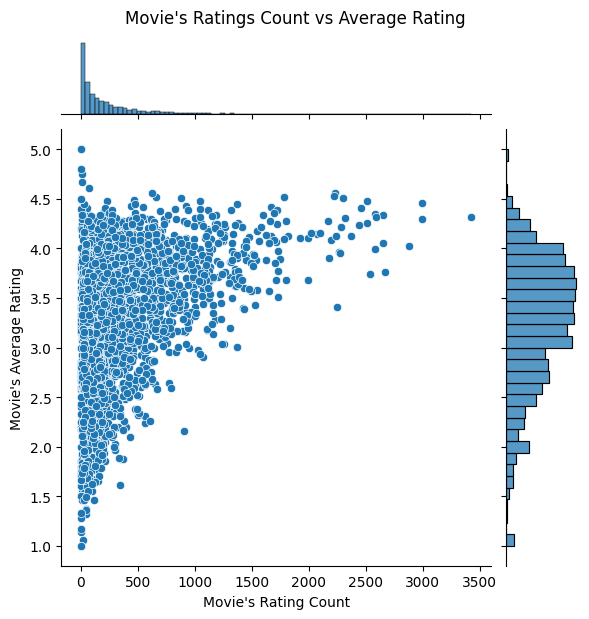

In [16]:
movie_stats = ratings.groupby('movie_id').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['rating_mean', 'rating_count']

g = sns.jointplot(data=movie_stats, x='rating_count', y='rating_mean', kind='scatter')
g.set_axis_labels("Movie's Rating Count", "Movie's Average Rating")
g.fig.suptitle("Movie's Ratings Count vs Average Rating", y=1.025)
plt.show()

## Temporal Dynamics Analysis

Understanding how user interactions change over time is critical for temporal evaluation strategies.

### Convert Timestamps and Analyze Time Range

In [23]:
# Convert timestamp to datetime
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Analyze time range
print(f"Dataset time range:")
print(f"  Earliest rating: {ratings['datetime'].min()}")
print(f"  Latest rating: {ratings['datetime'].max()}")
print(f"  Time span: {(ratings['datetime'].max() - ratings['datetime'].min()).days} days")
print(f"  Time span: {(ratings['datetime'].max() - ratings['datetime'].min()).days / 365.25:.2f} years")

Dataset time range:
  Earliest rating: 2000-04-25 23:05:32
  Latest rating: 2003-02-28 17:49:50
  Time span: 1038 days
  Time span: 2.84 years


### Interaction Volume Over Time

Analyze rating activity patterns at different time scales.

In [24]:
# Aggregate ratings by different time periods
ratings['date'] = ratings['datetime'].dt.date
ratings['year_month'] = ratings['datetime'].dt.to_period('M')
ratings['year_week'] = ratings['datetime'].dt.to_period('W')

# Daily ratings count
daily_counts = ratings.groupby('date').size()

# Weekly ratings count
weekly_counts = ratings.groupby('year_week').size()

# Monthly ratings count
monthly_counts = ratings.groupby('year_month').size()

print(f"Activity statistics:")
print(f"  Average ratings per day: {daily_counts.mean():.2f}")
print(f"  Average ratings per week: {weekly_counts.mean():.2f}")
print(f"  Average ratings per month: {monthly_counts.mean():.2f}")
print(f"  Peak daily activity: {daily_counts.max()} ratings")
print(f"  Minimum daily activity: {daily_counts.min()} ratings")

Activity statistics:
  Average ratings per day: 961.74
  Average ratings per week: 6712.81
  Average ratings per month: 28577.40
  Peak daily activity: 63654 ratings
  Minimum daily activity: 1 ratings


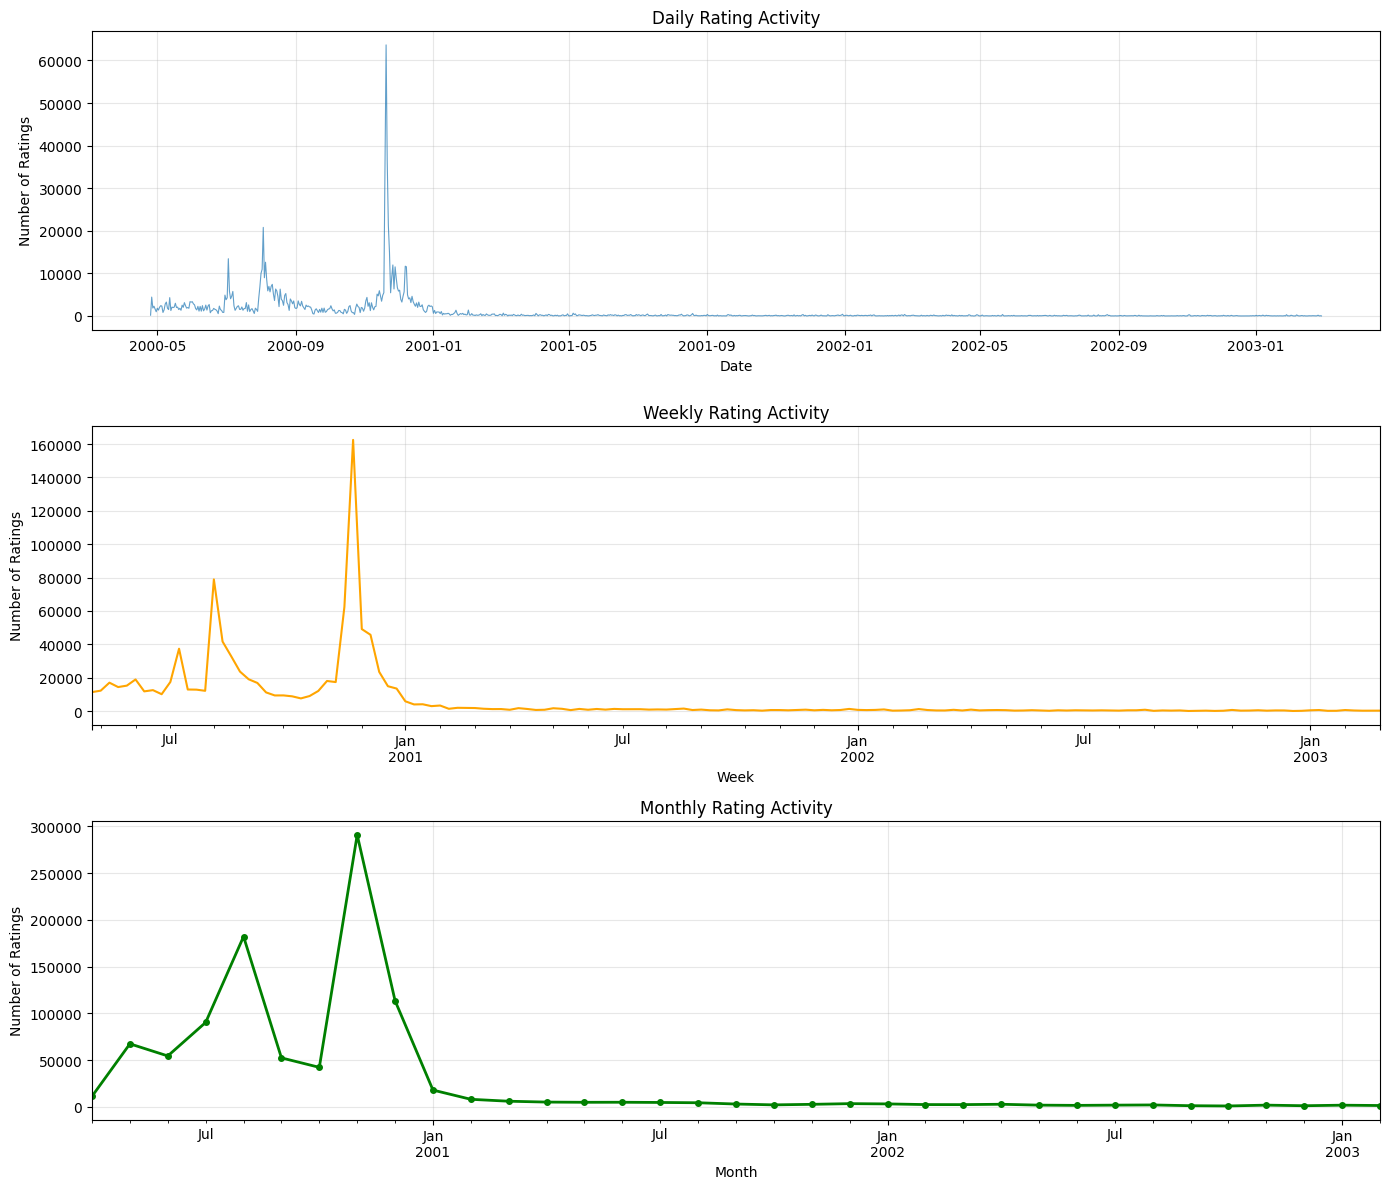

In [25]:
# Plot interaction volume over time at different granularities
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Daily activity
axes[0].plot(daily_counts.index, daily_counts.values, linewidth=0.8, alpha=0.7)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Ratings')
axes[0].set_title('Daily Rating Activity')
axes[0].grid(True, alpha=0.3)

# Weekly activity
weekly_counts.plot(ax=axes[1], linewidth=1.5, color='orange')
axes[1].set_xlabel('Week')
axes[1].set_ylabel('Number of Ratings')
axes[1].set_title('Weekly Rating Activity')
axes[1].grid(True, alpha=0.3)

# Monthly activity
monthly_counts.plot(ax=axes[2], linewidth=2, color='green', marker='o', markersize=4)
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Number of Ratings')
axes[2].set_title('Monthly Rating Activity')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()